In [400]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.linear_model
import xgboost as xgb
from pytil.object import Namespace as O
from pytil.utility import *
from helpers import *
from pytil.quickvis import canvas

ss = slice(None)
canvas(16, 2)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:36:52.977475. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [346]:
N_TRAIN, N_TEST = 623817, 640430
df = pd.read_csv('train.csv', index_col=0)
df.index = df.index - N_TRAIN
dg = pd.read_csv('test.csv', index_col=0)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:16:10.254267. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Explore

In [ ]:
xfeats = 'x0 x1 x2 x3A x3B x3C x3D x3E x4 x5 x6'.split()

In [292]:
grp = df.groupby(['Market', 'Stock'])
desc = grp.describe()

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-29 22:22:11.674487. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [724]:
agrp = np.abs(df).groupby('Market Stock'.split())
wycorr = agrp.corr().loc[(slice(None), slice(None), 'Weight',), ('y',)]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:16.747078. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


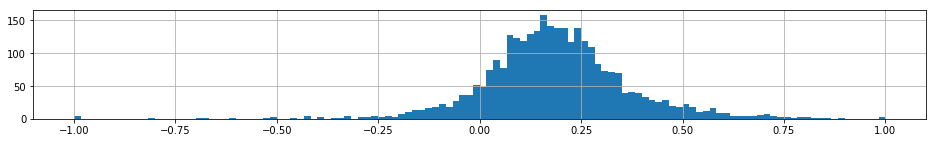

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:06:31.051520. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [725]:
res = agrp.corr().loc[(ss, ss, 'y'), 'x4']
res.hist(bins=120)

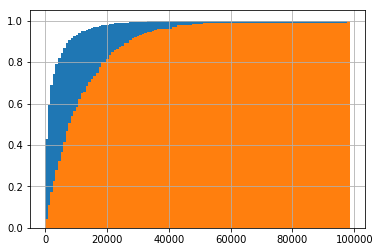

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 09:11:33.695777. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [341]:
hist(grp.sum().Weight, bins=120, normed=True, cumulative=True)
hist(grp.sum().Weight, weighted=True, bins=120, normed=True, cumulative=True)

In [394]:
listthing = [int(x[0]) for x in sorted(df[['Stock', col]].values, key=lambda x: x[1])[::-1][-1000:-500]]
thing = list(set(listthing))

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 10:21:28.672423. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


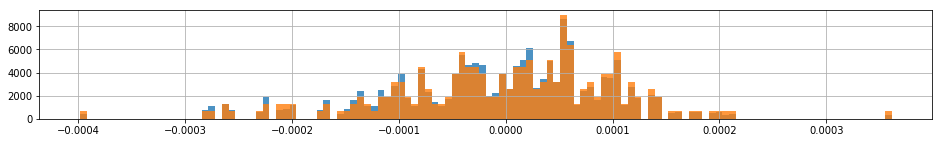

247 0.000397538089951


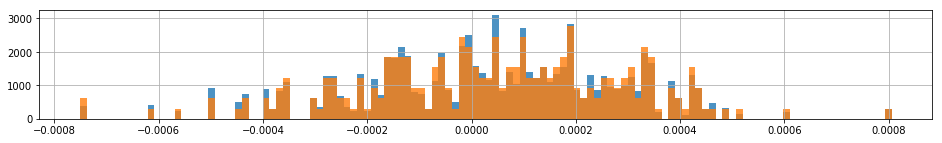

251 0.0867626267151


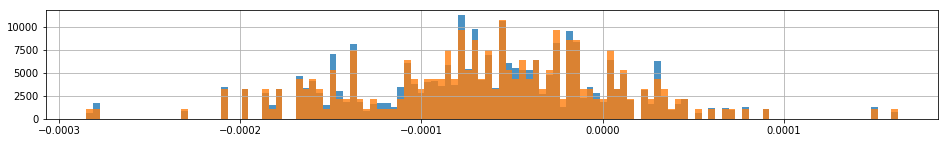

251 0.204674285411


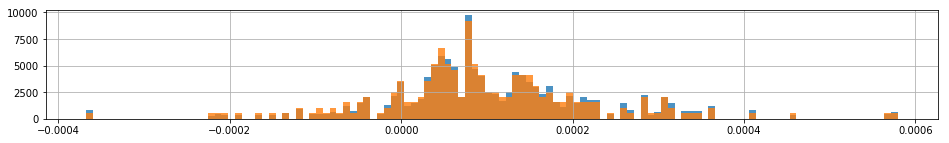

247 1.42622882884e-05


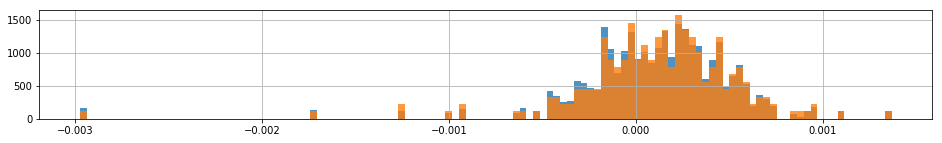

247 1.6676556502e-31


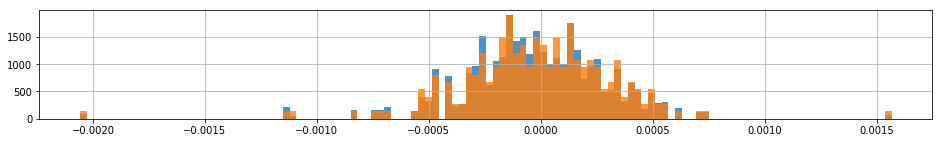

247 9.22979973834e-14


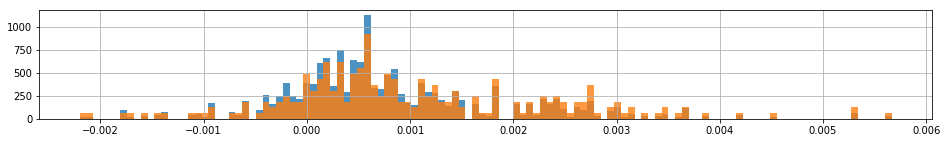

249 9.59286090927e-06


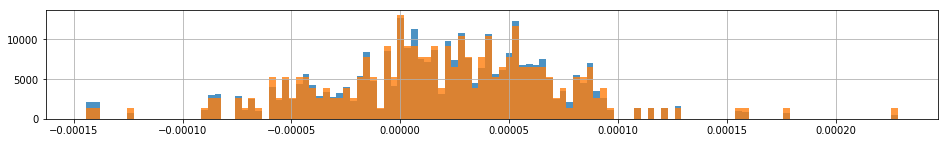

247 0.0197578412492


C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:25:03.178891. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [744]:
col = 'y'
from scipy import stats
ii = list(range(df.Stock.min(), df.Stock.max() + 1))
random.shuffle(ii)
ii = ii[:8]
#ii = thing
for i in range(len(ii)):
    q = df.query('Stock == ' + str(ii[i]))
    trans = q[col]
    trans.hist(bins=120, weights=q.Weight, normed=True, alpha=.8)
    trans.hist(bins=120, normed=True, alpha=.8)
    plt.show()
    print(len(trans), stats.normaltest(trans).pvalue)

# Simple model

In [ ]:
ident = pd.get_dummies(df[['Market', 'Stock']], columns=['Market', 'Stock'])

In [740]:
dh = pd.concat([df, dg])

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:21:07.102413. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [746]:
ranked = 1 - dh.groupby(['Market', 'Stock']).transform(lambda x: x.rank(pct=True, method='max', ascending=False))
ranked = ranked[[c for c in ranked.columns if c != 'Weight' and c != 'y']]
ranked.columns = [c + ' rank' for c in ranked.columns]

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:29:16.422723. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
#thedf = pd.concat([df, ident], axis=1)

In [784]:
thedf = dh[['Day'] + xfeats]
#thedf = pd.concat([thedf, ranked], axis=1)

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:55:08.296143. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [777]:
import random
xdf = thedf.iloc[:N_TRAIN]
labels = list(xdf.columns)
n = len(df)
perm = list(range(n))
random.shuffle(perm)
tr, cv = perm[:n // 2], perm[n // 2:]
x = xdf.values
y = df.y.values
weight = df.Weight.values

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:52:16.921508. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [778]:
dmat = O()
dmat.tr = xgb.DMatrix(x[tr], y[tr], feature_names=labels, weight=weight[tr])
dmat.cv = xgb.DMatrix(x[cv], y[cv], feature_names=labels, weight=weight[cv])

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:52:24.798404. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [790]:
model = None
boost_hp = dict(
    objective = 'reg:linear',
    booste = 'gbtree',
    max_depth = 9,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    tree_method = 'exact',
    gamma = 0,
    min_child_weight = 0,
    eta = 0.1,
    seed = 0
)
cv_hp = dict(
    num_boost_round = 500,
    early_stopping_rounds = 50,
    nfold = 10,
    stratified = True,
    seed = 0,
)
learn_hp = dict(
    num_boost_round = 500,
    early_stopping_rounds = 50,
    evals = [[dmat.cv, 'CV']]
)
model = xgb.train(boost_hp, dmat.tr, **learn_hp)

[0]	CV-rmse:0.449988
Will train until CV-rmse hasn't improved in 50 rounds.
[1]	CV-rmse:0.404989
[2]	CV-rmse:0.36449
[3]	CV-rmse:0.328041
[4]	CV-rmse:0.295237
[5]	CV-rmse:0.265713
[6]	CV-rmse:0.239142
[7]	CV-rmse:0.215228
[8]	CV-rmse:0.193705
[9]	CV-rmse:0.174335
[10]	CV-rmse:0.156901
[11]	CV-rmse:0.141211
[12]	CV-rmse:0.12709
[13]	CV-rmse:0.114381
[14]	CV-rmse:0.102943
[15]	CV-rmse:0.092649
[16]	CV-rmse:0.083384
[17]	CV-rmse:0.075046
[18]	CV-rmse:0.067541
[19]	CV-rmse:0.060787
[20]	CV-rmse:0.054709
[21]	CV-rmse:0.049238
[22]	CV-rmse:0.044314
[23]	CV-rmse:0.039883
[24]	CV-rmse:0.035895
[25]	CV-rmse:0.032306
[26]	CV-rmse:0.029075
[27]	CV-rmse:0.026168
[28]	CV-rmse:0.023552
[29]	CV-rmse:0.021197
[30]	CV-rmse:0.019078
[31]	CV-rmse:0.01717
[32]	CV-rmse:0.015454
[33]	CV-rmse:0.013909
[34]	CV-rmse:0.012519
[35]	CV-rmse:0.011267
[36]	CV-rmse:0.010141
[37]	CV-rmse:0.009128
[38]	CV-rmse:0.008216
[39]	CV-rmse:0.007395
[40]	CV-rmse:0.006657
[41]	CV-rmse:0.005992
[42]	CV-rmse:0.005394
[43]	CV-rmse

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:58:00.465111. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


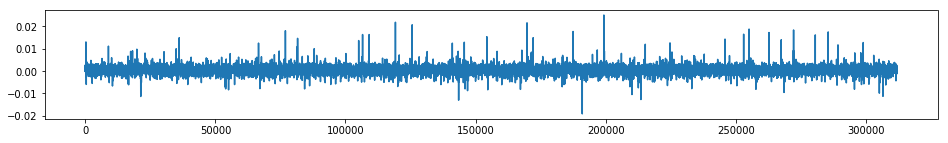

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:59:37.550971. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [791]:
y_ = model.predict(dmat.cv)
plt.plot(y_)

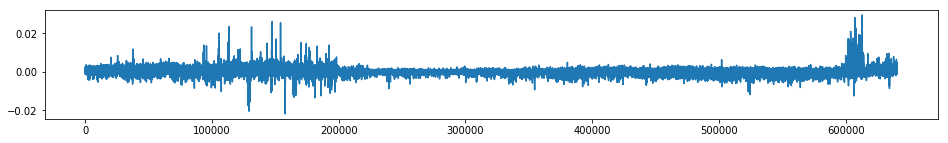

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:59:37.910821. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [792]:
xtest = thedf.iloc[N_TRAIN:].values
dmat.test = xgb.DMatrix(xtest, feature_names=labels)
ytest_ = model.predict(dmat.test)
plt.plot(ytest_); plt.show()

In [ ]:
for i, tree in enumerate(model.get_dump()):
    print('<{}>'.format(i))
    print(tree)
    if i >= 10:
        break

In [786]:
ypred = pd.Series(ytest_).rename('y')
ypred.index.name = 'Index'
ypred.to_csv('model1.csv', header=True)
omodel = model

C:\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\simplejson\encoder.py:291: DeprecationWarning: Interpreting naive datetime as local 2018-01-30 21:55:29.126624. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## predict y-rank

# Split model

# Abs model